# **Load and Explore the Data**

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("crawford/gene-expression")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/gene-expression


In [4]:
import os

files = os.listdir("/kaggle/input/gene-expression")
print("Available files:", files)

Available files: ['data_set_ALL_AML_independent.csv', 'data_set_ALL_AML_train.csv', 'actual.csv']


In [5]:
import pandas as pd

# Correct paths


actual_df = pd.read_csv(f"{path}/actual.csv")
train_df = pd.read_csv(f"{path}/data_set_ALL_AML_train.csv")
independent_df = pd.read_csv(f"{path}/data_set_ALL_AML_independent.csv")

print("Files loaded successfully!")


Files loaded successfully!


In [6]:
print(train_df.shape)
print(independent_df.shape)
print(actual_df.head())

(7129, 78)
(7129, 70)
   patient cancer
0        1    ALL
1        2    ALL
2        3    ALL
3        4    ALL
4        5    ALL


# **Data Preparation**

In [7]:
actual_df = actual_df.replace({'ALL':0,'AML':1})
labels = ['ALL', 'AML']

/tmp/ipykernel_31/4049934003.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  actual_df = actual_df.replace({'ALL':0,'AML':1})


In [8]:
print(actual_df.head())

   patient  cancer
0        1       0
1        2       0
2        3       0
3        4       0
4        5       0


In [9]:
train_to_keep = [col for col in train_df.columns if "call" not in col]
test_to_keep = [col for col in independent_df.columns if "call" not in col]

X_train_tr = train_df[train_to_keep]
X_test_tr = independent_df[test_to_keep]

In [10]:
train_columns_titles = ['Gene Description', 'Gene Accession Number', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', 
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38']

test_columns_titles = ['Gene Description', 'Gene Accession Number','39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', '50', '51', '52', '53',  '54', '55', '56', '57', '58', '59',
       '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72']


X_train_tr = X_train_tr.reindex(columns=train_columns_titles)
X_test_tr = X_test_tr.reindex(columns=test_columns_titles)

X_train = X_train_tr.T
X_test = X_test_tr.T

In [11]:
X_train.columns = X_train.iloc[1]
X_train = X_train.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

X_test.columns = X_test.iloc[1]
X_test = X_test.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

In [12]:
X_train = X_train.reset_index(drop=True)
y_train = actual_df[actual_df.patient <= 38].reset_index(drop=True)

X_test = X_test.reset_index(drop=True)
y_test = actual_df[actual_df.patient > 38].reset_index(drop=True)

# Training Models - Model Choices for Interpretability

Logistic Regression

✅ Logistic Regression accuracy: 0.971


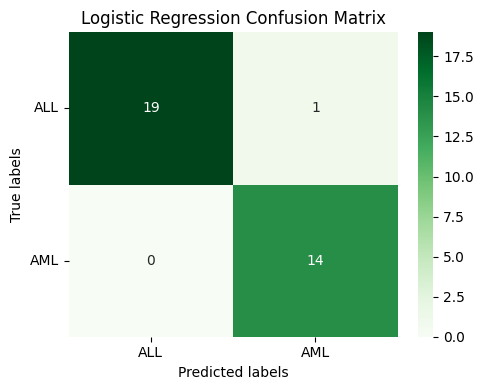


🔍 Top 10 Genes That Influence Logistic Regression Decision:

Gene Accession Number
Y00787_s_at                0.000186
M19507_at                  0.000175
Z19554_s_at                0.000173
M27891_at                  0.000170
M17733_at                  0.000167
M25079_s_at                0.000150
M96326_rna1_at             0.000149
M11147_at                  0.000136
AFFX-HUMRGE/M10098_3_at    0.000134
M14483_rna1_s_at           0.000132
dtype: float64


/tmp/ipykernel_31/1785185095.py:41: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


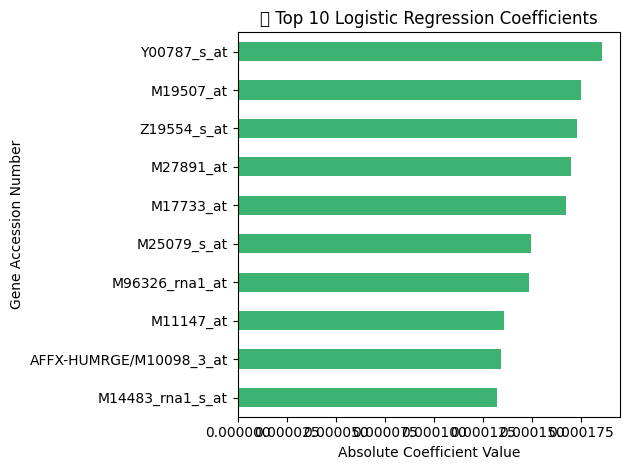

In [16]:
from sklearn.linear_model import LogisticRegression
import numpy as np

# Train Logistic Regression
lr_model = LogisticRegression(random_state=0, max_iter=1000)
lr_model.fit(X_train, y_train.iloc[:, 1])

# Predict
lr_pred = lr_model.predict(X_test)

# Accuracy
print('✅ Logistic Regression accuracy:', round(accuracy_score(y_test.iloc[:, 1], lr_pred), 3))

# Confusion Matrix
cm_lr = confusion_matrix(y_test.iloc[:, 1], lr_pred)

plt.figure(figsize=(5, 4))
ax = plt.subplot()
sns.heatmap(cm_lr, annot=True, ax=ax, fmt='g', cmap='Greens')

labels = ['ALL', 'AML']
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Logistic Regression Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=0)
plt.tight_layout()
plt.show()

# Q2: Interpretation – Top 10 Influential Genes (absolute coefficient values)
print("\n🔍 Top 10 Genes That Influence Logistic Regression Decision:\n")
lr_coeffs = pd.Series(np.abs(lr_model.coef_[0]), index=X_train.columns)
top_lr_features = lr_coeffs.sort_values(ascending=False).head(10)
print(top_lr_features)

# Optional bar plot for visualization
top_lr_features.plot(kind='barh', color='mediumseagreen')
plt.title("🎯 Top 10 Logistic Regression Coefficients")
plt.xlabel("Absolute Coefficient Value")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


XGBoost classification

XGBoost accuracy: 0.912


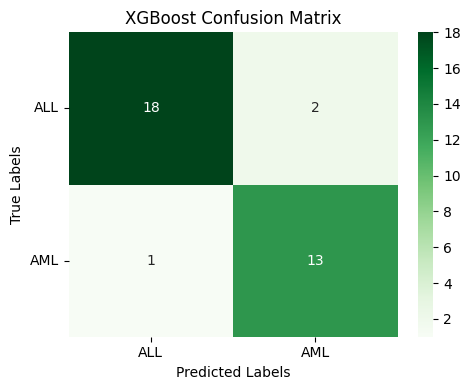

In [13]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure y_train and y_test have proper columns
# Assuming column 1 holds the class labels (e.g., 'class')
xgb_model = xgb.XGBClassifier(random_state=0)

xgb_model.fit(X_train, y_train.iloc[:, 1])

# Predict on test set
xgb_pred = xgb_model.predict(X_test)

# Accuracy
print('XGBoost accuracy:', round(accuracy_score(y_test.iloc[:, 1], xgb_pred), 3))

# Confusion matrix
cm_xgb = confusion_matrix(y_test.iloc[:, 1], xgb_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
ax = plt.subplot()
sns.heatmap(cm_xgb, annot=True, fmt='g', cmap='Greens', ax=ax)

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('XGBoost Confusion Matrix')

# Set class labels if known, e.g., ['ALL', 'AML']
labels = ['ALL', 'AML']
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=0)
plt.tight_layout()
plt.show()


Decision Tree classifier

✅ Decision Tree Classifier accuracy: 0.912


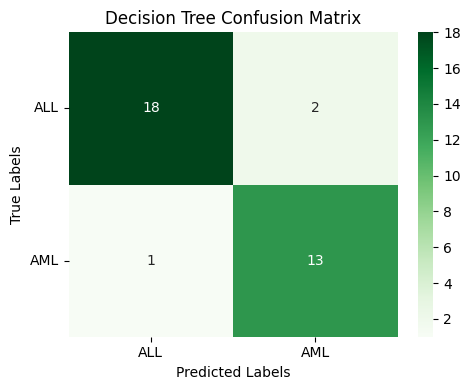


🔍 Top 10 Important Genes (features) used by the Decision Tree:

Gene Accession Number
X95735_at    1.0
X89066_at    0.0
X89059_at    0.0
X87904_at    0.0
X87870_at    0.0
X87852_at    0.0
X87843_at    0.0
X87838_at    0.0
X87767_at    0.0
X87613_at    0.0
dtype: float64


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


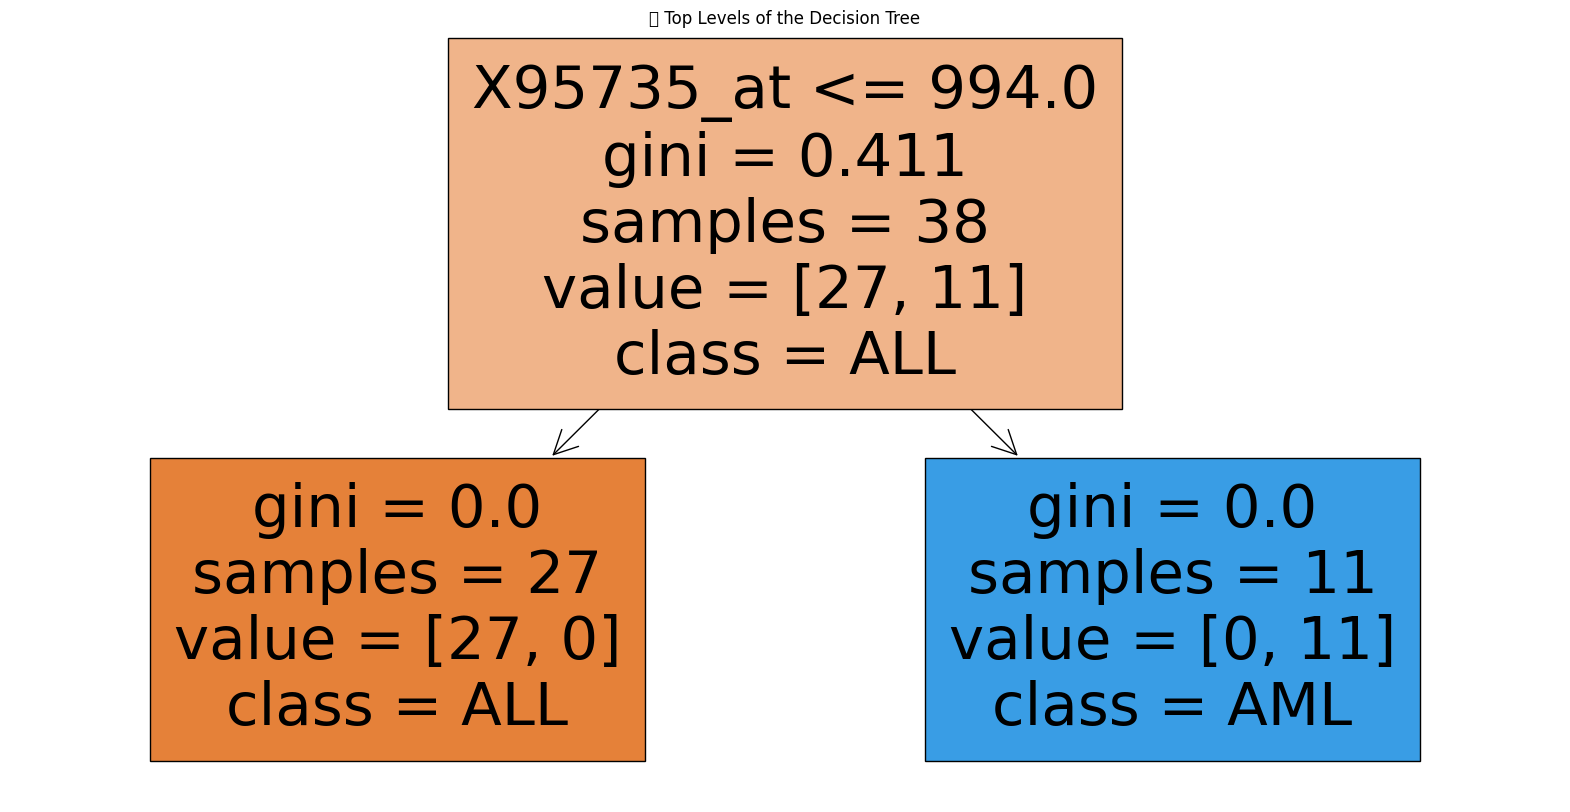

In [14]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Step 1: Train the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=0)
dt_model.fit(X_train, y_train.iloc[:, 1])

# Step 2: Make predictions
dt_pred = dt_model.predict(X_test)

# Step 3: Evaluate the model
accuracy = round(accuracy_score(y_test.iloc[:, 1], dt_pred), 3)
print('✅ Decision Tree Classifier accuracy:', accuracy)

# Step 4: Confusion matrix
cm_dt = confusion_matrix(y_test.iloc[:, 1], dt_pred)

plt.figure(figsize=(5, 4))
ax = plt.subplot()
sns.heatmap(cm_dt, annot=True, fmt='g', cmap='Greens', ax=ax)

labels = ['ALL', 'AML']
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Decision Tree Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=0)
plt.tight_layout()
plt.show()

# Q2: Interpretation – Top Important Genes
print("\n🔍 Top 10 Important Genes (features) used by the Decision Tree:\n")
importances = pd.Series(dt_model.feature_importances_, index=X_train.columns)
top_features = importances.sort_values(ascending=False).head(10)
print(top_features)

# Optional: Plot decision tree structure (useful for small trees)
plt.figure(figsize=(20, 10))
plot_tree(
    dt_model,
    feature_names=X_train.columns,
    class_names=['ALL', 'AML'],
    filled=True,
    max_depth=2  # limit to shallow levels for clarity
)
plt.title("🌳 Top Levels of the Decision Tree")
plt.show()


Random Forest 

✅ Random Forest accuracy: 0.912


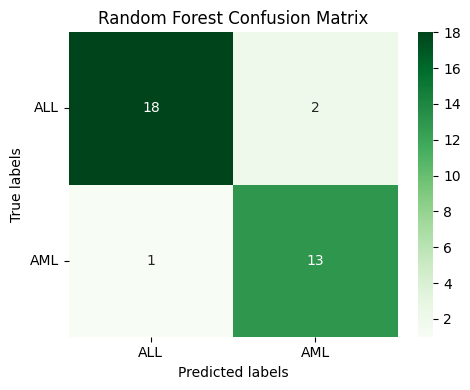


🔍 Top 10 Important Genes (features) from Random Forest:

Gene Accession Number
X95735_at    0.533333
M55150_at    0.383333
M31166_at    0.049357
U46499_at    0.016667
M27891_at    0.016452
U51096_at    0.000214
M82882_at    0.000214
L02321_at    0.000214
J03133_at    0.000214
X87767_at    0.000000
dtype: float64


/tmp/ipykernel_31/420747737.py:50: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


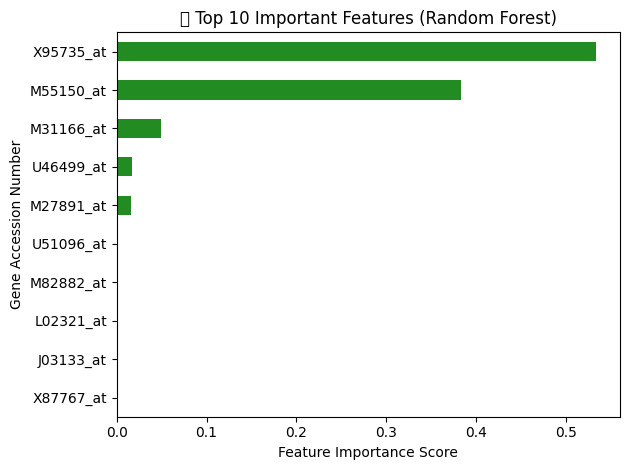

In [15]:
from sklearn.ensemble import RandomForestClassifier


# Define best parameters and train model
rf_best_param = {
    'bootstrap': False,
    'max_features': 0.6,
    'min_samples_leaf': 8,
    'min_samples_split': 3,
    'n_estimators': 60
}

rf_model = RandomForestClassifier(random_state=0, **rf_best_param)
rf_model.fit(X_train, y_train.iloc[:, 1])

# Predict
rf_pred = rf_model.predict(X_test)

# Evaluate
accuracy = round(accuracy_score(y_test.iloc[:, 1], rf_pred), 3)
print('✅ Random Forest accuracy:', accuracy)

# Confusion Matrix
cm_rf = confusion_matrix(y_test.iloc[:, 1], rf_pred)

plt.figure(figsize=(5, 4))
ax = plt.subplot()
sns.heatmap(cm_rf, annot=True, ax=ax, fmt='g', cmap='Greens')

labels = ['ALL', 'AML']
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Random Forest Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=0)
plt.tight_layout()
plt.show()

# Q2: Interpretation – Top 10 Important Genes
print("\n🔍 Top 10 Important Genes (features) from Random Forest:\n")
rf_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
top_rf_features = rf_importances.sort_values(ascending=False).head(10)
print(top_rf_features)

# Optional bar plot for top features
top_rf_features.plot(kind='barh', color='forestgreen')
plt.title("🎯 Top 10 Important Features (Random Forest)")
plt.xlabel("Feature Importance Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Top features based on Logistic Regression coefficients and standard deviation:

Gene Accession Number
M25079_s_at           1.873432
Y00787_s_at           1.104047
HG1428-HT1428_s_at    0.982914
Z19554_s_at           0.979603
D49824_s_at           0.954625
Z84721_cds2_at        0.812649
M11147_at             0.796164
M27891_at             0.776066
D86974_at             0.772257
M91036_rna1_at        0.749336
dtype: float64


/tmp/ipykernel_31/3079137303.py:19: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


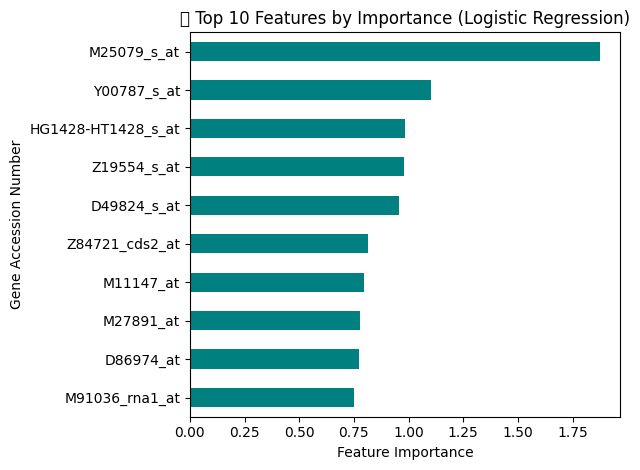

In [17]:
# Get the coefficients (absolute values)
coefficients = np.abs(lr_model.coef_.ravel())

# Calculate feature importance by multiplying coefficient with feature's standard deviation
fe = pd.Series(np.std(X_train, 0) * coefficients, index=X_train.columns)

# Sort features based on their importance
fe_sorted = fe.sort_values(ascending=False)

# Show top features
print("Top features based on Logistic Regression coefficients and standard deviation:\n")
print(fe_sorted.head(10))

# Optional: Visualize the top features
fe_sorted.head(10).plot(kind='barh', color='teal')
plt.title("🎯 Top 10 Features by Importance (Logistic Regression)")
plt.xlabel("Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Model Expained - Visualize Decision Tree

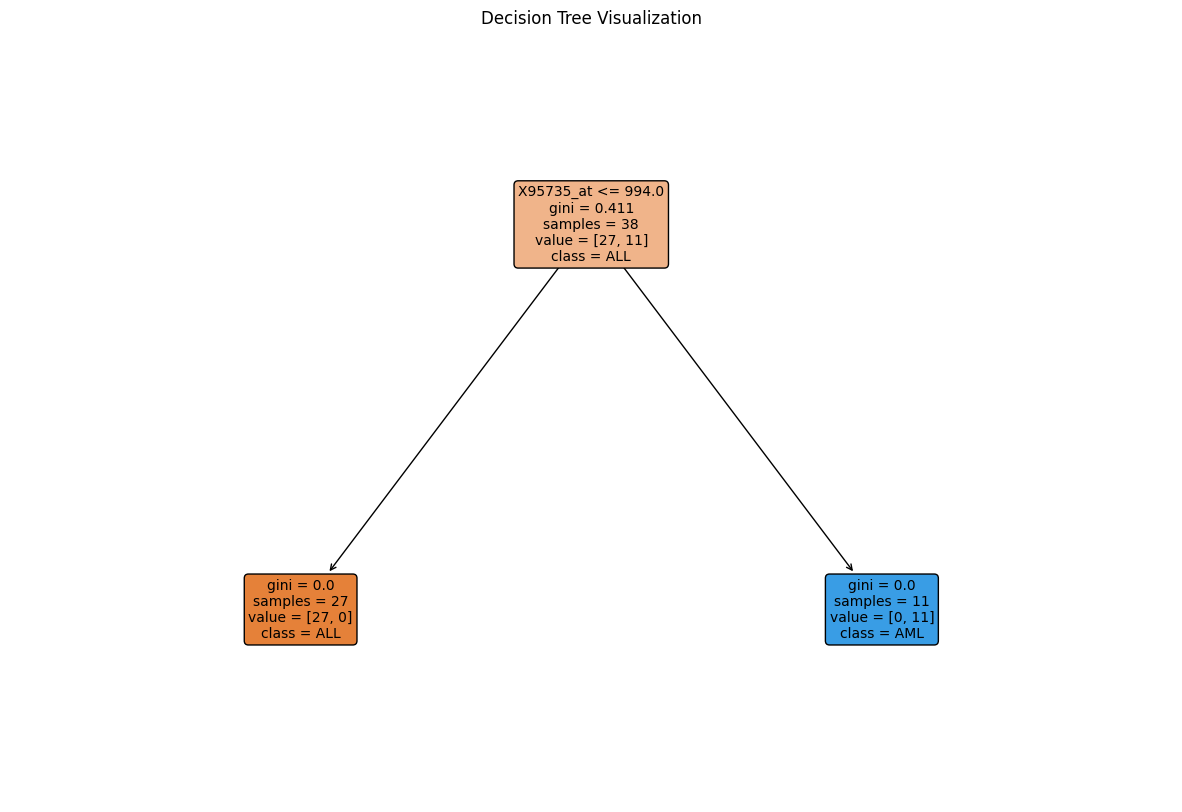

In [18]:
# Assuming dt_model is already trained as:
# dt_model = DecisionTreeClassifier(random_state=0)
# dt_model.fit(X_train, y_train.iloc[:, 1])

# Define the feature names and labels for plotting
feature_names = list(X_train.columns)
labels = ['ALL', 'AML']

# Plot the decision tree
fig = plt.figure(figsize=(15, 10))  # Increase figure size for better visibility
_ = plot_tree(dt_model,
              feature_names=feature_names,
              class_names=labels,
              filled=True,
              fontsize=10,
              rounded=True)

# Optional: Title for the plot
plt.title("Decision Tree Visualization")
plt.show()


Model Expained - SHAP Summary Plot for Random Forest

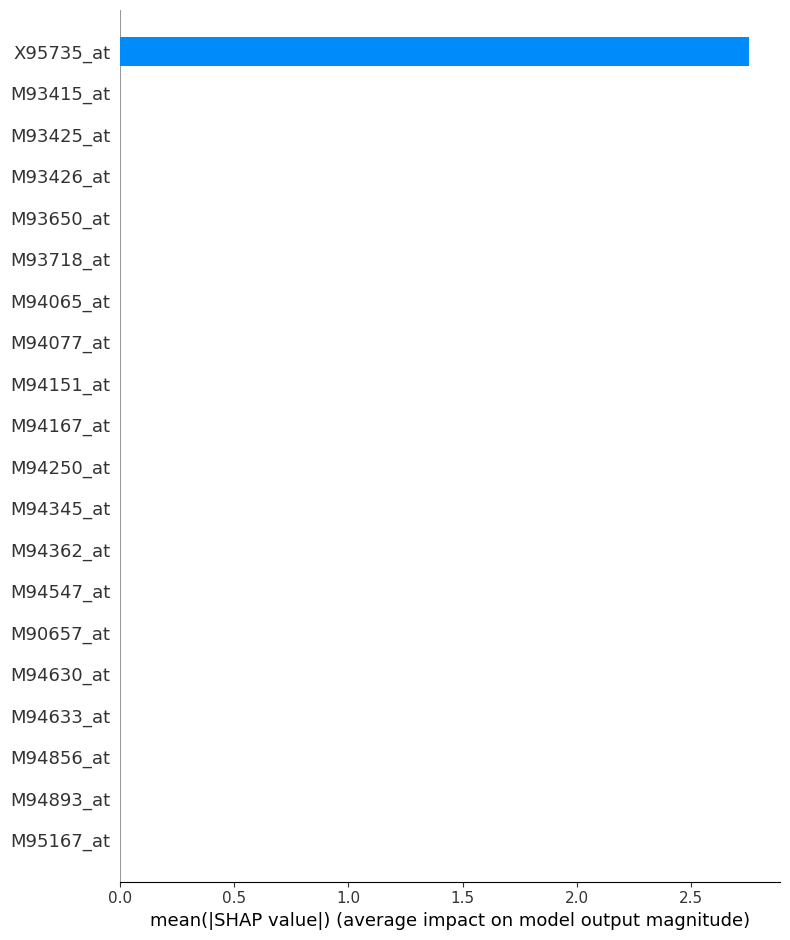

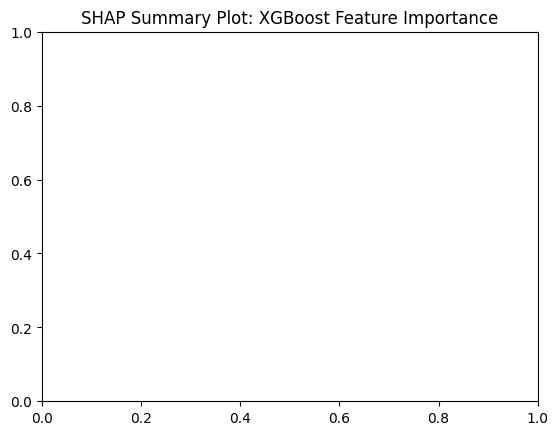

In [21]:
import shap

# Assuming the XGBoost model (xgb_model) is already trained:
# xgb_model = xgb.XGBClassifier(random_state=0)
# xgb_model.fit(X_train, y_train.iloc[:, 1])

# Initialize the SHAP Explainer for the XGBoost model
explainer_xgb = shap.Explainer(xgb_model)

# Calculate SHAP values for the test set
shap_values_xgb = explainer_xgb.shap_values(X_test)

# Create the SHAP summary plot (using 'bar' plot_type for multi-output)
fig = plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_xgb, X_test, plot_type="bar")

# Optional: Display title for the plot
plt.title("SHAP Summary Plot: XGBoost Feature Importance")
plt.show()


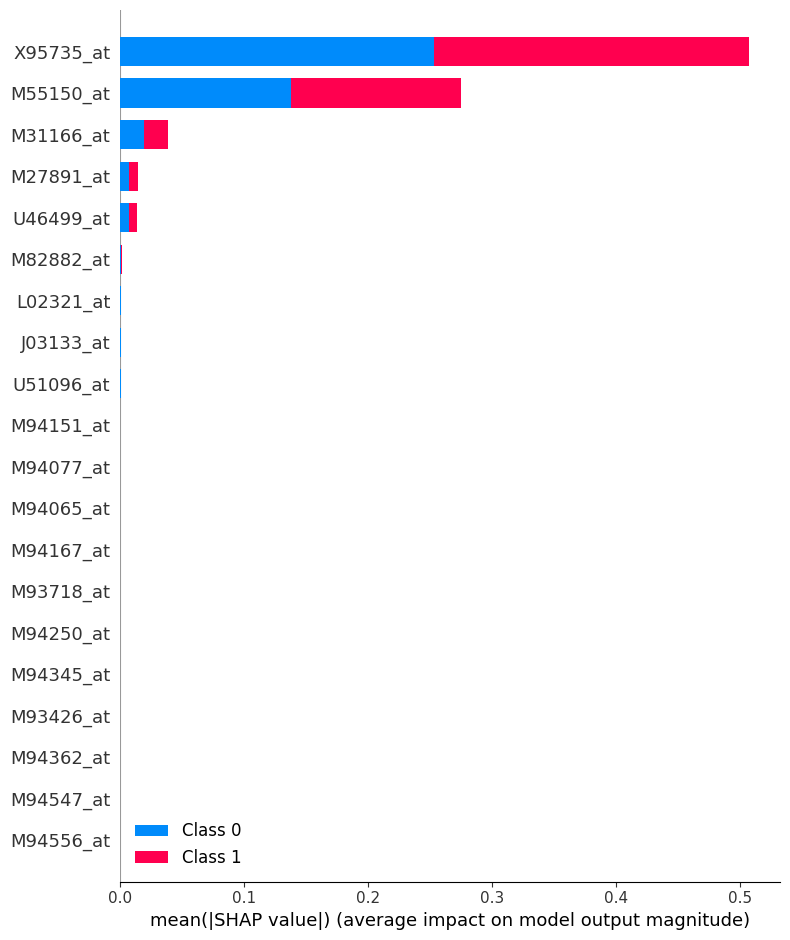

In [22]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)
figure = plt.figure()
shap.summary_plot(shap_values, X_test)

Model Expained - SHAP Summary Plot for XGBoost Model

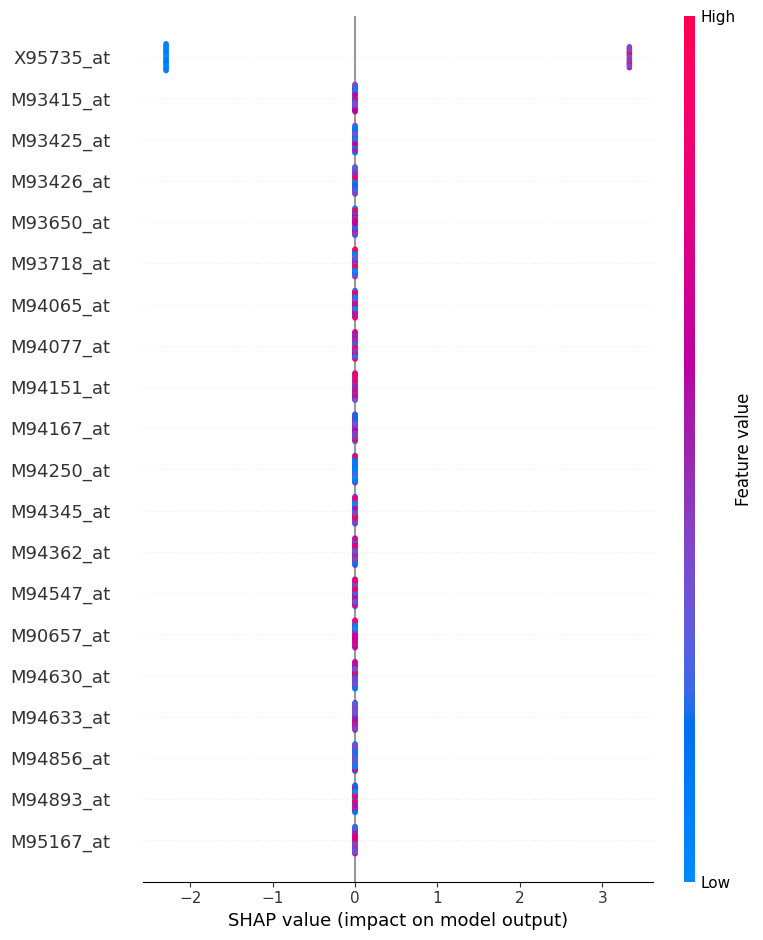

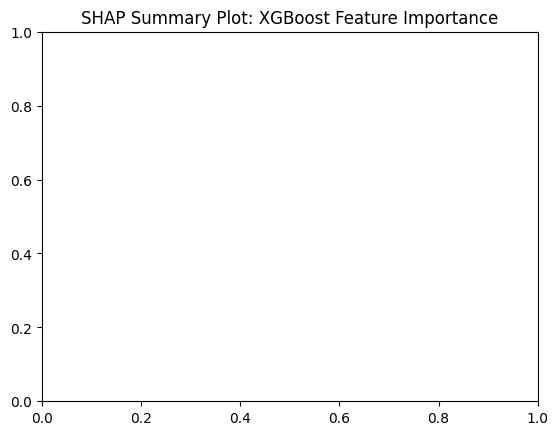

In [23]:

# Assuming the XGBoost model (xgb_model) is already trained:
# xgb_model = xgb.XGBClassifier(random_state=0)
# xgb_model.fit(X_train, y_train.iloc[:, 1])

# Initialize the SHAP Explainer for the XGBoost model
explainer_xgb = shap.Explainer(xgb_model)

# Calculate SHAP values for the test set
shap_values_xgb = explainer_xgb.shap_values(X_test)

# Create the SHAP summary plot
fig = plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_xgb, X_test, plot_type="dot")

# Optional: Display title for the plot
plt.title("SHAP Summary Plot: XGBoost Feature Importance")
plt.show()


# Clustering

KMeans clustering

In [24]:
from sklearn.cluster import KMeans

# Apply KMeans clustering to the training data (with 2 clusters for AML and ALL)
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train)

# Confusion matrix: compare cluster labels with true labels
cm = confusion_matrix(kmeans.labels_, y_train.iloc[:, 1])

# Print the confusion matrix
print("Confusion Matrix:\n", cm)

# Find the maximum value in each row of the confusion matrix (most correct assignments)
max_vals = np.amax(cm, axis=1)

# Calculate the purity by summing the maximum values and dividing by the number of samples
purity = np.sum(max_vals) / len(y_train.iloc[:, 1])

print(f'Purity of the kmeans clustering: {purity:.3f}')


Confusion Matrix:
 [[ 0  4]
 [27  7]]
Purity of the kmeans clustering: 0.816


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


Agglomerative Clustering 

In [25]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

# Apply Agglomerative Clustering to the training data (with 2 clusters for AML and ALL)
agg_clustering = AgglomerativeClustering(n_clusters=2).fit(X_train)

# Confusion matrix: compare cluster labels with true labels
cm = confusion_matrix(agg_clustering.labels_, y_train.iloc[:, 1])

# Print the confusion matrix
print("Confusion Matrix:\n", cm)

# Find the maximum value in each row of the confusion matrix (most correct assignments)
max_vals = np.amax(cm, axis=1)

# Calculate the purity by summing the maximum values and dividing by the number of samples
purity = np.sum(max_vals) / len(y_train.iloc[:, 1])

print(f'Purity of the AgglomerativeClustering clustering: {purity:.3f}')


Confusion Matrix:
 [[27  7]
 [ 0  4]]
Purity of the AgglomerativeClustering clustering: 0.816


Spectral Clustering

In [26]:
from sklearn.cluster import SpectralClustering

# Apply Spectral Clustering to the training data (with 2 clusters for AML and ALL)
spectral_clustering = SpectralClustering(n_clusters=2, random_state=0, affinity='nearest_neighbors').fit(X_train)

# Confusion matrix: compare cluster labels with true labels
cm = confusion_matrix(spectral_clustering.labels_, y_train.iloc[:, 1])

# Print the confusion matrix
print("Confusion Matrix:\n", cm)

# Find the maximum value in each row of the confusion matrix (most correct assignments)
max_vals = np.amax(cm, axis=1)

# Calculate the purity by summing the maximum values and dividing by the number of samples
purity = np.sum(max_vals) / len(y_train.iloc[:, 1])

print(f'Purity of the SpectralClustering clustering: {purity:.3f}')


Confusion Matrix:
 [[27  1]
 [ 0 10]]
Purity of the SpectralClustering clustering: 0.974


Principal Component Analysis 

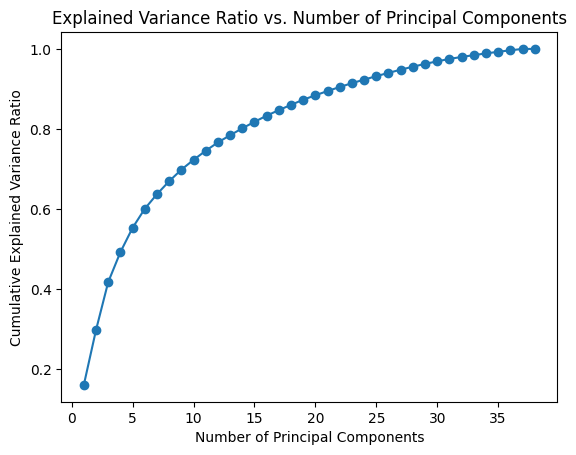

In [27]:
from sklearn.decomposition import PCA

# Fit PCA to the training data (X_train)
pca = PCA()
X_pca = pca.fit_transform(X_train)

# Convert the PCA result to a dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

# Get the explained variance ratio and the cumulative variance ratio
explained_var_ratio = pca.explained_variance_ratio_
cumulative_var_ratio = np.cumsum(explained_var_ratio)

# Plot the cumulative explained variance ratio
plt.plot(range(1, len(cumulative_var_ratio) + 1), cumulative_var_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Principal Components')
plt.show()
